In [3]:
!apt-get update
!apt-get install -y cuda

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [914 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,088 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,439 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:13 h

#Laplace equation


In [5]:
%%writefile laplace.cu
#include <stdio.h>
#include <iostream>
#include <string>
#include <fstream>
#include <cuda_runtime.h>
using namespace std;


__global__ void compute_delta(double* data, double* delta, int x_steps, int y_steps, double hx, double hy) {
    int num_threads = blockDim.x * gridDim.x;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    for (int idx = tid; idx < (x_steps-2)*(y_steps-2); idx += num_threads) {
        int xid = idx % (x_steps-2) + 1;
        int yid = idx / (x_steps-2) + 1;
        delta[xid + yid * x_steps] = (
            data[xid + 1 + yid * x_steps] - 2 * data[xid + yid * x_steps] + data[xid - 1 + yid * x_steps]
        ) / hx / hx + (
            data[xid + yid * x_steps + x_steps] - 2 * data[xid + yid * x_steps] + data[xid + yid * x_steps - x_steps]
        ) / hy / hy;
    }
}

__global__ void clear_memory(double* to_clear) {
    *to_clear = 0;
}

__global__ void add_with_tau(double* data, double* delta, double tau, int x_steps, int y_steps) {
    int num_threads = blockDim.x * gridDim.x;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    for (int idx = tid; idx < (x_steps-2)*(y_steps-2); idx += num_threads) {
        int xid = idx % (x_steps-2) + 1;
        int yid = idx / (x_steps-2) + 1;
        data[xid + yid * x_steps] += tau * delta[xid + yid * x_steps];
    }
}

__global__ void compute_l1_norm(double* data1, double* data2, double* norm, int x_steps, int y_steps) {
    int num_threads = blockDim.x * gridDim.x;
    double candidate;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    for (int idx = tid; idx < (x_steps-2)*(y_steps-2); idx += num_threads) {
        int xid = idx % (x_steps-2) + 1;
        int yid = idx / (x_steps-2) + 1;
        candidate = abs(data1[xid + yid * x_steps] - data2[xid + yid * x_steps]); // Don't compare boundary since it's fixed
        if (candidate > *norm) {
            *norm = candidate;
        }
    }
}

__global__ void assign_values(double* target, double* source, int x_steps, int y_steps) {
    int num_threads = blockDim.x * gridDim.x;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    for (int idx = tid; idx < (x_steps-2)*(y_steps-2); idx += num_threads) {
        int xid = idx % (x_steps-2) + 1;
        int yid = idx / (x_steps-2) + 1;
        target[xid + yid * x_steps] = source[xid + yid * x_steps];
    }
}

__global__ void set_boundary_conditions(double* data, int x_steps, int y_steps) {
    int num_threads = blockDim.x * gridDim.x;
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    for (int idx = tid; idx < (x_steps) * (y_steps); idx += num_threads) {
        int xid = idx % (x_steps);
        int yid = idx / (x_steps);
        data[xid + yid * x_steps] = (xid == 0) ? 0 : (xid == (x_steps - 1)) ? 0 : (yid == 0) ? 1 : (yid == (y_steps - 1)) ? 0 : 0;
    }
}

int main(int argc, char* argv[]) {
    std::ofstream output_file;
    output_file.open(argv[4]);
    size_t x_steps = atoi(argv[1]);
    size_t y_steps = atoi(argv[2]);
    int num_threads = atoi(argv[3]);
    double error = 0;
    double* error_control;
    double tau = atof(argv[5]);
    double *u_current, *u_next, *delta;
    int iteration_count = 0;
    double tolerance = 1e-16;
    cudaMallocManaged((void**)&u_current, x_steps * y_steps * sizeof(double));
    cudaMallocManaged((void**)&u_next, x_steps * y_steps * sizeof(double));
    cudaMallocManaged((void**)&delta, x_steps * y_steps * sizeof(double));
    cudaMallocManaged((void**)&error_control, sizeof(double));
    double hy = 1.0 / y_steps;
    double hx = 1.0 / x_steps;
    int num_blocks = 1 + (x_steps-2) * (y_steps-2) / num_threads;

    set_boundary_conditions <<<num_blocks, num_threads>>> (u_current, x_steps, y_steps);
    set_boundary_conditions <<<num_blocks, num_threads>>> (u_next, x_steps, y_steps);
    cudaDeviceSynchronize();

    error = 100;


    while (error > tolerance) {
        compute_delta <<<num_blocks, num_threads>>> (u_current, delta, x_steps, y_steps, hx, hy);
        assign_values <<<num_blocks, num_threads>>> (u_current, u_next, x_steps, y_steps);
        add_with_tau <<<num_blocks, num_threads>>> (u_next, delta, tau, x_steps, y_steps);
        cudaDeviceSynchronize();
        clear_memory <<<num_blocks, num_threads>>> (error_control);
        compute_l1_norm <<<num_blocks, num_threads>>> (u_next, u_current, error_control, x_steps, y_steps);
        cudaMemcpy(&error, error_control, sizeof(double), cudaMemcpyDeviceToHost);
        iteration_count++;
        if (iteration_count % 100 == 0) {
            std::cout << "Iteration number " << iteration_count << ", L1 norm " << error << std::endl;
        }
    }

    std::cout << error << std::endl;
    cudaDeviceSynchronize();

    for (int i = 0; i < x_steps; i++) {
        for (int j = 0; j < y_steps; j++) {
            output_file << u_next[i + j * x_steps] << ',';
        }
        output_file << std::endl;
    }


    cudaFree(u_current);
    cudaFree(u_next);
    cudaFree(delta);
    cudaFree(error_control);
    output_file.close();
}

Overwriting laplace.cu


In [6]:
!nvcc laplace.cu -o laplace

In [8]:
!./laplace 100 100 100 "laplace.txt" 0.00001 # x_steps, y_steps, num_threads, output file name, tau

Iteration number 100, L1 norm 0.00107413
1e-51


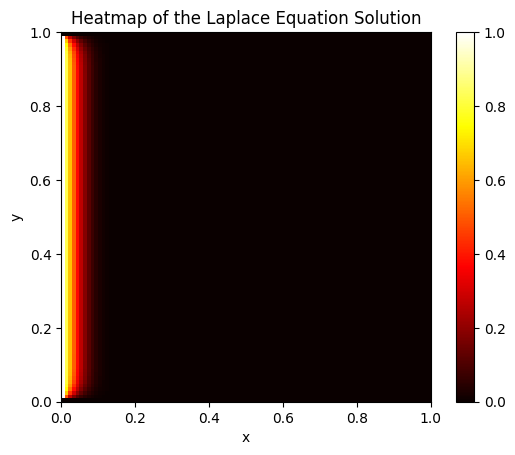

In [11]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
M = 100

data = []
with open('laplace.txt', 'r') as file:
    for line in file:
        row = [float(val) for val in line.strip().split(',') if val]
        data.append(row)

u = np.array(data)

if u.shape != (N, M):
    raise ValueError(f"Expected data shape ({N}, {M}), but got {u.shape}")

# Plot the heatmap
plt.imshow(u, extent=[0, 1, 0, 1], origin='lower', cmap='hot')
plt.colorbar()
plt.title('Heatmap of the Laplace Equation Solution')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('heatmap.png')
plt.show()

#Histogram

<ipython-input-28-91ee12a096b1>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((X_DIM, Y_DIM), Image.ANTIALIAS)


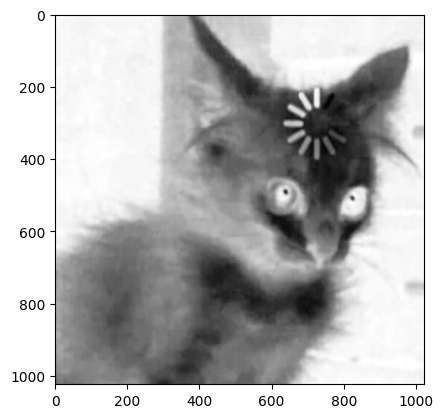

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

X_DIM= 1024
Y_DIM = 1024

img = Image.open("unhappy.png")
img.load()

original_width, original_height = img.size
img = img.resize((X_DIM, Y_DIM), Image.ANTIALIAS)

data = np.asarray(img, dtype="int32")[:, :, 2].flatten()
plt.imshow(data.reshape(X_DIM, Y_DIM), cmap='Greys')
plt.show()

In [29]:
np.savetxt("unhappy.txt", data.flatten(), fmt = "%u")

In [30]:
%%writefile histogram.cu

#include <stdio.h>
#include <iostream>
#include <vector>
#include <string>
#include <fstream>
#include <cuda_runtime.h>
#include <cuda.h>

#define X_DIM 1024
#define Y_DIM 1024

__global__ void compute_histogram_renamed(int* img_data, int* hist, int length) {
    // Calculate the global thread index
    int global_tid = blockIdx.x * blockDim.x + threadIdx.x;

    // Use shared memory to avoid bank conflicts and reduce atomic operations
    __shared__ int shared_hist[256];

    // Initialize shared histogram
    if (threadIdx.x < 256) {
        shared_hist[threadIdx.x] = 0;
    }
    __syncthreads();

    // Each thread updates the shared histogram
    if (global_tid < length) {
        atomicAdd(&shared_hist[img_data[global_tid]], 1);
    }
    __syncthreads();

    // Transfer the shared histogram to the global histogram
    if (threadIdx.x < 256) {
        atomicAdd(&hist[threadIdx.x], shared_hist[threadIdx.x]);
    }
}

int main() {
    int length = X_DIM * Y_DIM;
    int *host_img_data = (int*)malloc(length * sizeof(int));
    int *host_hist = (int*)calloc(256, sizeof(int));

    std::string line = "";
    std::ifstream inputFile("unhappy.txt");

    for (int i = 0; i < length; ++i) {
        if (!(inputFile >> line)) {
            std::cerr << "Error reading data at index " << i << std::endl;
            return -1;
        }
        try {
            host_img_data[i] = std::stoi(line);
        } catch (const std::invalid_argument& e) {
            std::cerr << "Invalid input at index " << i << ": " << line << std::endl;
            return -1;
        } catch (const std::out_of_range& e) {
            std::cerr << "Out of range input at index " << i << ": " << line << std::endl;
            return -1;
        }
    }

    int *device_img_data;
    int *device_hist;

    cudaMalloc((void**)&device_img_data, length * sizeof(int));
    cudaMalloc((void**)&device_hist, 256 * sizeof(int));

    cudaMemcpy(device_img_data, host_img_data, length * sizeof(int), cudaMemcpyHostToDevice);
    cudaMemset(device_hist, 0, 256 * sizeof(int));

    int threads_per_block = 256;
    int num_blocks = (length + threads_per_block - 1) / threads_per_block;

    compute_histogram_renamed<<<num_blocks, threads_per_block>>>(device_img_data, device_hist, length);

    cudaMemcpy(host_hist, device_hist, 256 * sizeof(int), cudaMemcpyDeviceToHost);

    std::ofstream outputHistogramFile("histogram.txt");
    for (int i = 0; i < 256; i++)
        outputHistogramFile << host_hist[i] << "\n";

    free(host_img_data);
    free(host_hist);
    cudaFree(device_img_data);
    cudaFree(device_hist);

    return 0;
}



Overwriting histogram.cu


In [31]:
!nvcc -o histogram histogram.cu

In [32]:
!./histogram

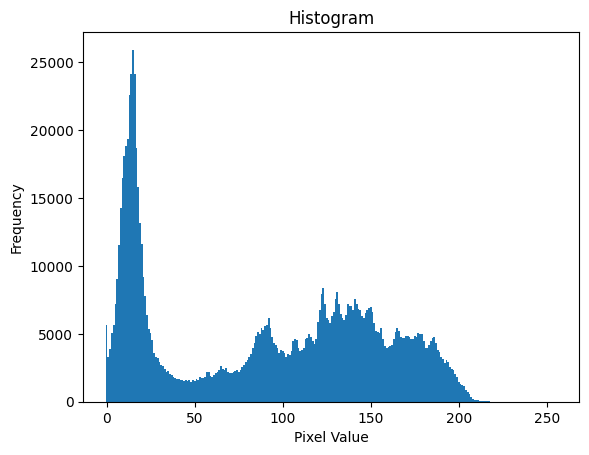

In [34]:
# Load the histogram data
histogram = np.loadtxt("histogram.txt", dtype=int)

# Plot the histogram
plt.bar(range(256), histogram, width=1)
plt.title("Histogram")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.savefig('hist.png')
plt.show()

#Blurring filter

<ipython-input-45-c8c5835e6703>:10: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((N, M), Image.ANTIALIAS)


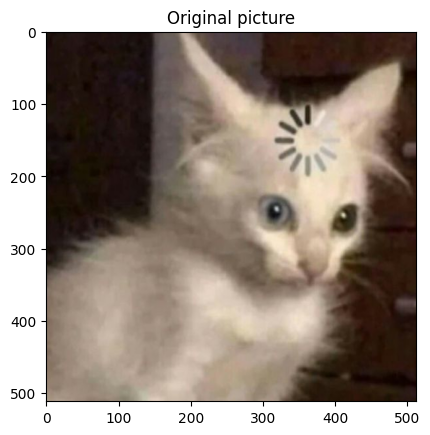

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

N = 512
M = 512

img = Image.open("unhappy.png")
img = img.resize((N, M), Image.ANTIALIAS)
data = np.asarray(img, dtype=np.float32).flatten()

# Save data to text file
np.savetxt("unhappy_filter.txt", data, fmt='%f')

# Display the original image
plt.imshow(img)
plt.title("Original picture")
plt.show()


In [84]:
%%writefile image_filter.cu

#include <stdio.h>
#include <iostream>
#include <vector>
#include <string>
#include <fstream>
#include <cuda_runtime.h>
#include <math.h>

const int N = 512;
const int M = 512;
const int P_MEDIAN = 7;
const int P_GAUSSIAN = 11;

__device__ int getGid() {
    int tid = threadIdx.x + blockDim.x * threadIdx.y +
              blockDim.x * blockDim.y * threadIdx.z;
    int bid = blockIdx.x + gridDim.x * blockIdx.y +
              gridDim.x * gridDim.y * blockIdx.z;
    int gid = bid * blockDim.x * blockDim.y * blockDim.z + tid;
    return gid;
}

__device__ void Array_sort(float *array, int n) {
    int i = 0, j = 0;
    float temp = 0.0;
    for (i = 0; i < n; i++) {
        for (j = 0; j < n - 1; j++) {
            if (array[j] > array[j + 1]) {
                temp = array[j];
                array[j] = array[j + 1];
                array[j + 1] = temp;
            }
        }
    }
}

__device__ float Array_sum(float *array, int n) {
    float sum = 0.0;
    for (int i = 0; i < n; i++)
        sum += array[i];
    return sum;
}

__global__ void medianFilter(float* im, int size, int channel_offset) {
    size_t gid = getGid();
    float value = 0.0;
    int channel_size = size / 3;

    if (gid < channel_size) {
        int offset = gid + channel_offset;

        if (((gid % M) >= P_MEDIAN) && ((gid % M) <= (M - P_MEDIAN - 1))) {
            float stencil[2 * P_MEDIAN + 1];
            for (int k = 0; k < 2 * P_MEDIAN + 1; k++)
                stencil[k] = im[offset - P_MEDIAN * 3 + k * 3];
            Array_sort(stencil, 2 * P_MEDIAN + 1);
            value = stencil[P_MEDIAN];
        }
        __syncthreads();
        im[offset] = value;
        __syncthreads();
    }

    if (gid < channel_size) {
        int offset = gid + channel_offset;

        if (((gid / M) >= P_MEDIAN) && ((gid / M) <= (N - P_MEDIAN - 1))) {
            float stencil[2 * P_MEDIAN + 1];
            for (int k = 0; k < 2 * P_MEDIAN + 1; k++)
                stencil[k] = im[offset + (k - P_MEDIAN) * M * 3];
            Array_sort(stencil, 2 * P_MEDIAN + 1);
            value = stencil[P_MEDIAN];
        }
        __syncthreads();
        im[offset] = value;
        __syncthreads();
    }
}

__global__ void gaussianBlur(float* im, int size, int channel_offset) {
    size_t gid = getGid();
    float sigma = 0.9;
    float G[2 * P_GAUSSIAN + 1];
    for (int k = 0; k < 2 * P_GAUSSIAN + 1; k++) {
        G[k] = 1 / sqrt(2 * 3.1415 * sigma) * exp(-(k - P_GAUSSIAN) * (k - P_GAUSSIAN) / (2 * sigma * sigma));
    }
    int channel_size = size / 3;

    if (gid < channel_size) {
        int offset = gid + channel_offset;
        float value = im[offset];

        if (((gid % M) >= P_GAUSSIAN) && ((gid % M) <= (M - P_GAUSSIAN - 1))) {
            float stencil[2 * P_GAUSSIAN + 1];
            for (int k = 0; k < 2 * P_GAUSSIAN + 1; k++)
                stencil[k] = im[offset - P_GAUSSIAN * 3 + k * 3] * G[k];
            value = Array_sum(stencil, 2 * P_GAUSSIAN + 1);
        }
        __syncthreads();
        im[offset] = value;
        __syncthreads();
    }

    if (gid < channel_size) {
        int offset = gid + channel_offset;
        float value = im[offset];

        if (((gid / M) >= P_GAUSSIAN) && ((gid / M) <= (N - P_GAUSSIAN - 1))) {
            float stencil[2 * P_GAUSSIAN + 1];
            for (int k = 0; k < 2 * P_GAUSSIAN + 1; k++)
                stencil[k] = im[offset + (k - P_GAUSSIAN) * M * 3] * G[k];
            value = Array_sum(stencil, 2 * P_GAUSSIAN + 1);
        }
        __syncthreads();
        im[offset] = value;
        __syncthreads();
    }
}

void processFilter(const std::string& inputFile, const std::string& medianOutputFile, const std::string& gaussianOutputFile) {
    std::string a = "";
    std::ifstream fileInput(inputFile);
    std::vector<float> image(N * M * 3);
    for (auto n = 0; n < N * M * 3; ++n) {
        fileInput >> a;
        image[n] = std::stof(a);
    }

    float* imageCuda;
    cudaMalloc(&imageCuda, N * M * 3 * sizeof(float));

    cudaMemcpy(imageCuda, image.data(), N * M * 3 * sizeof(float), cudaMemcpyHostToDevice);

    // Perform median filter for each channel
    for (int channel = 0; channel < 3; ++channel) {
        int channel_offset = channel * N * M;
        medianFilter<<<(N * M + 255) / 256, 256>>>(imageCuda, N * M * 3, channel_offset);
    }
    cudaDeviceSynchronize();
    cudaMemcpy(image.data(), imageCuda, N * M * 3 * sizeof(float), cudaMemcpyDeviceToHost);
    std::ofstream medianOutput(medianOutputFile);
    for (int i = 0; i < N * M * 3; i++)
        medianOutput << image[i] << "\n";

    // Reload image data for Gaussian blur
    fileInput.clear();
    fileInput.seekg(0, std::ios::beg);
    for (auto n = 0; n < N * M * 3; ++n) {
        fileInput >> a;
        image[n] = std::stof(a);
    }
    cudaMemcpy(imageCuda, image.data(), N * M * 3 * sizeof(float), cudaMemcpyHostToDevice);

    // Perform Gaussian blur for each channel
    for (int channel = 0; channel < 3; ++channel) {
        int channel_offset = channel * N * M;
        gaussianBlur<<<(N * M + 255) / 256, 256>>>(imageCuda, N * M * 3, channel_offset);
    }
    cudaDeviceSynchronize();
    cudaMemcpy(image.data(), imageCuda, N * M * 3 * sizeof(float), cudaMemcpyDeviceToHost);
    std::ofstream gaussianOutput(gaussianOutputFile);
    for (int i = 0; i < N * M * 3; i++)
        gaussianOutput << image[i] << "\n";

    cudaFree(imageCuda);
}

int main() {
    processFilter("unhappy_filter.txt", "median_filter.txt", "gaussian_blur.txt");
    return 0;
}



Overwriting image_filter.cu


In [85]:
!nvcc -o image_filter image_filter.cu

In [86]:
!./image_filter

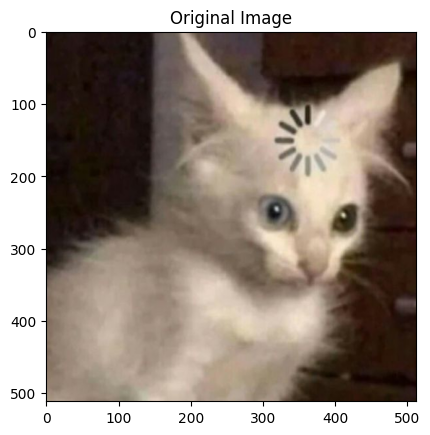

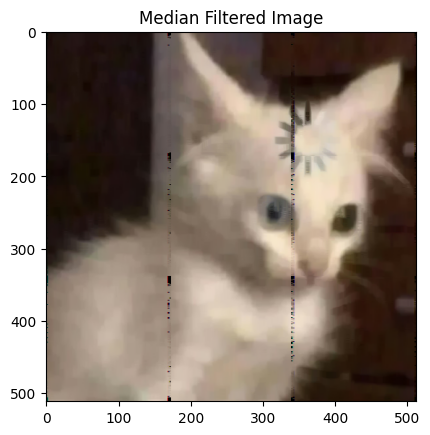

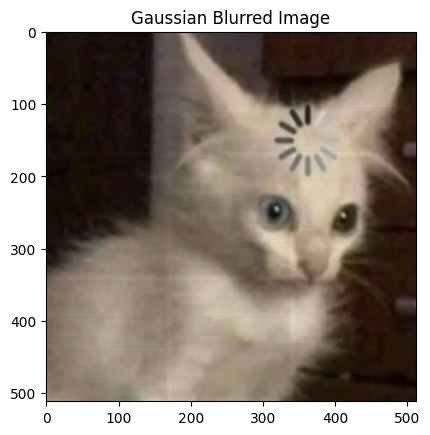

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load the blurred images
def load__image(file_name):
    data = np.loadtxt(file_name, dtype=np.float32)
    return data.reshape((512, 512, 3))


median_data = load_blurred_image("unhappy_filter.txt")
median_img = Image.fromarray(np.uint8(median_data))
plt.imshow(median_img)
plt.title("Original Image")
plt.savefig('original_image')
plt.show()

# Read and display the median filtered image
median_data = load_blurred_image("median_filter.txt")
median_img = Image.fromarray(np.uint8(median_data))
plt.imshow(median_img)
plt.title("Median Filtered Image")
plt.savefig('median_filtered_image')
plt.show()

# Read and display the Gaussian blurred image
gaussian_data = load_blurred_image("gaussian_blur.txt")
gaussian_img = Image.fromarray(np.uint8(gaussian_data))
plt.imshow(gaussian_img)
plt.title("Gaussian Blurred Image")
plt.savefig('gaussian_filtered_image')
plt.show()
